# PROJECT 2 : TEAM 11

Members: Talia Tandler, SeungU Lyu

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

In [2]:
import matplotlib.pyplot as plt
import numpy as np

http://www.worldometers.info/world-population/us-population/
US pop in 2017 = 324,459,463

https://www.cdc.gov/vaccines/imz-managers/coverage/childvaxview/data-reports/mmr/trend/index.html
MMR immunization rate in 2017 = 90.7%

https://www.acha.org/documents/Programs_Services/ConEd/Measles_Update_2015_Implications_for_the_College_Setting.pdfMMR 
Measles importatoin number = 33/year

https://wwwnc.cdc.gov/travel/yellowbook/2018/infectious-diseases-related-to-travel/measles-rubeola
Measles incubation period 11 days average, infectious period 2-4 days before rash to after rash.

https://www.researchgate.net/figure/Daily-average-number-of-contacts-per-person-in-age-group-j-The-average-number-of_fig2_228649013
Daily average number of contacts per person. 

https://academic.oup.com/jid/article/189/Supplement_1/S91/825077
1999 overall immunity for measles were expected to be 93% for US population.

https://www.statista.com/statistics/195943/birth-rate-in-the-united-states-since-1990/
Birth rate = 12.2/1000 per year = 0.0122 
Death rate = 8.4/1000 per year = 0.0084


In [3]:
us_pop = 324459463  #current US population
init_im = 0.93      #initial immunity of the US population
MMR_vac = .907      #MMR vaccination rate in 2017
a_rate = 0.9        #Possibility of getting measles if you come into contact with someone that has it
b_rate = 0.0122    #US birth rate
d_rate = 0.0084    #US death rate
r_rate = 0.25      #US recovery rate from measles. Typical recovery is 4 days, so 1/4 will recover within 1 day
i_rate = 0.091     #US rate from incubation period of 11 days to infected
c_num = 12         #number of people someone infected comes into contact with

12

In [4]:
def make_system (us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate):
    """Make a system object for the SCIR model
    
    us_pop: Total US population
    init_im: Initial Population Immunity
    vac_rate: Vaccination rate for newborn
    b_rate: birth rate per 1000 people
    d_rate: death rate per 1000 people
    r_rate: recovery rate for infected people
    i_rate: rate of incubation group moving to infectious group
    c_num: initial contact number for individuals 
    a_rate: Possibility of getting measles if you come into contact with someone that has it
    
    return: System object"""
    
    init = State(S = int(us_pop*(1 - init_im)), C = 0, I = 0, R = int(us_pop*init_im), T = 0, O = 0)
    #S: susceptible, C: incubation period, I: infected, R: recovered(immune to disease), T: total infected, O: outbreak status
    
    t0 = 0
    t_end = 365 * 10 #number of days in 10 years
    
    return System(init = init,
                  vac_rate = vac_rate,
                  b_rate = b_rate,
                  d_rate = d_rate,
                  r_rate = r_rate,
                  i_rate = i_rate,
                  c_num = c_num,
                  a_rate = a_rate,
                  t0 = t0,
                  t_end = t_end)

In [5]:
def update_func(state, time, system, contact):
    """Update the SCIR model
    
    state: starting variables of SCIR
    t: time step
    system: includes alpha,beta,gamma,omega rates
    contact: current contact number for the state
    
    """
    
    unpack(system)
    
    s,c,i,r,t,o = state
    
    #posibility of change in C on major outbreak.
    probability = 1 - exp(-0.1*i)
    
    #outbreak status check
    if o == 0 and i >= 3:
        o = 1    #indicates there is a measles outbreak
    
    #if measles outbreak is happening, change the contact number
    if o == 1:
        if flip(probability) and contact > 0:
            contact -= 1
    
    #end the outbreak when balance between C and I happens
    if o == 1 and c <= 10 and i <= 3 and contact == 0:
        c = 0
        i = 0
        o = 0
        contact = c_num
            
    #current population
    current_pop = s+c+i+r
    
    #newborn babies number every day
    newborn = int((b_rate * (current_pop))/365)
    
    #importation of measles from other countries
    if flip(0.09):   #33 people come into the US each year with measles 
        i += 1
        t += 1
    
    #change rate for each status
    ds = int(newborn * (1-vac_rate) - (d_rate * s)/365)  #change in number of people susceptible
    dr1 = int(newborn * vac_rate - (d_rate * r)/365)     #change in number of people recovered/immune due to vaccination or death
    dc = int(contact * i * a_rate * (s/(s+r+c)))         #change in number of people moving to incubation period
    di = int(c * i_rate)                             #change in number of people moving from incubation period to infected
    dr2 = int(i * (r_rate))                        #change in number of people recoverecd/immune from not having measles anymore
  
    s += ds - dc      #number of people susceptible
    i += di - dr2     #number of people infected
    c += dc - di      #number of people in incubation period
    r += dr1 + dr2    #number of recovered people
    t += dc           #number of people in incubation period
    
    return State(S=s, C=c, I=i, R=r, T=t, O=o), contact

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    #creates timeframe to save daily states
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    #creating contact number with initial value c_num
    contact = c_num
    
    for time in linrange(t0, t_end):
        frame.row[time+1], contact = update_func(frame.row[time], time, system, contact)
    
    return frame

In [7]:
vac_rate = 1   #vaccination rate for newborn babies
system = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
results = run_simulation(system, update_func)

,S,C,I,R,T,O
0,22712162,0,0,301747300,0,0
1,22711640,0,0,301751199,0,0
2,22711118,0,0,301755099,0,0
3,22710596,0,0,301758999,0,0
4,22710074,0,0,301762899,0,0
5,22709552,0,1,301766799,1,0
6,22709030,0,1,301770699,1,0
7,22708508,0,1,301774599,1,0
8,22707986,0,1,301778499,1,0
9,22707464,0,1,301782398,1,0


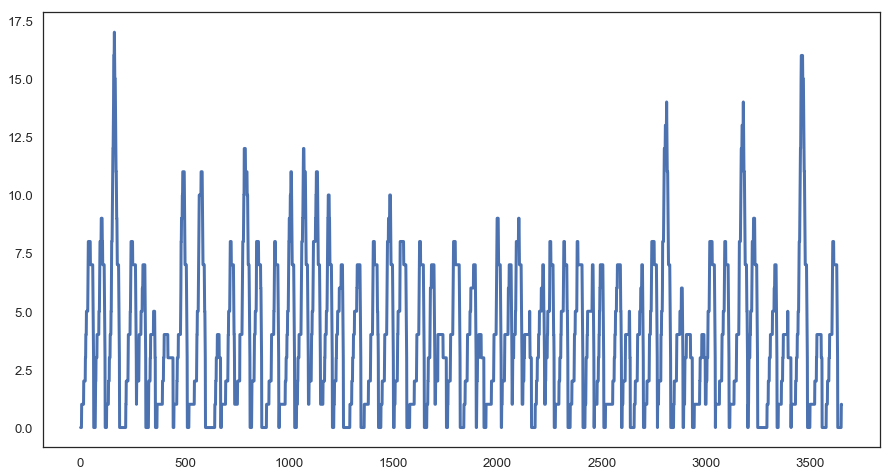

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(results.I,linewidth=3.0)

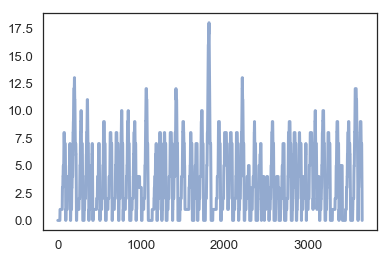

In [9]:
vac_rate = 0   #vaccination rate for newborn babies
system2 = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
results2 = run_simulation(system, update_func)
plot(results2['I'], label='L')

In [10]:
def sweep_vac(vac_rate_array):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    
    sweep = SweepSeries()
    for vac_rate in vac_rate_array:
        system = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
        results = run_simulation(system, update_func)
        sweep[system.vac_rate] = get_last_value(results.T)
    return sweep

In [ ]:
def sweep_vac2(vac_rate_array):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    
    frame = TimeFrame(columns=linspace(0,10,11))
    
    sweep = SweepSeries()
    for vac_rate in vac_rate_array:
        system = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
        results = run_simulation(system, update_func)
        sweep[system.vac_rate] = get_last_value(results.T)
    return sweep

In [40]:
frame = TimeFrame(columns=linspace(0,10,11))
sweep = SweepSeries()
for i in linspace(0,10,11):
    sweep[i] = int(i)*365

frame
frame.row[0.1] = sweep
frame

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0.1,0,365,730,1095,1460,1825,2190,2555,2920,3285,3650


In [11]:
vac_rate_array = linspace(0, 1, 11)
frame = sweep_vac(vac_rate_array)
frame

,values
0.0,7508
0.1,6871
0.2,7015
0.3,6628
0.4,6117
0.5,5556
0.6,4640
0.7,4070
0.8,3930
0.9,3623


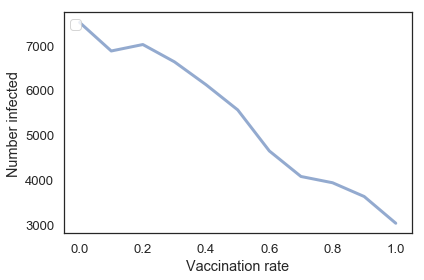

In [12]:
plot(frame)
    
decorate(xlabel='Vaccination rate',
         ylabel='Number infected',
         loc='upper left')

In [13]:
test = TimeSeries()
for t in linspace(0,100):
    test[t] = 1 - exp(-0.1*t)
test

,values
0.000000,0.000000
2.040816,0.184604
4.081633,0.335130
6.122449,0.457868
8.163265,0.557947
10.204082,0.639552
12.244898,0.706092
14.285714,0.760349
16.326531,0.804590
18.367347,0.840663


In [15]:
linspace(0,3650,11)

array([   0.,  365.,  730., 1095., 1460., 1825., 2190., 2555., 2920.,
       3285., 3650.])